# Making imports


In [1]:
import numpy as np
from matplotlib import pyplot as plt
import random
import scipy.optimize as opt
import torch
from tqdm import tqdm
from pyswarm import pso

random.seed(19680801)
np.random.seed(19680801)
torch.manual_seed(19680801)
torch.cuda.manual_seed(19680801)
torch.backends.cudnn.deterministic = True

# Task 4

## Generate random array

In [2]:
x = 3 * np.linspace(0, 1001, 1001) / 1000

y = 1 / (x**2 - 3*x + 2)

y[y < -100] = -100 + np.random.normal(0, 1, len(y[y < -100])) 
y[y > 100] = 100 + np.random.normal(0, 1, len(y[y > 100])) 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


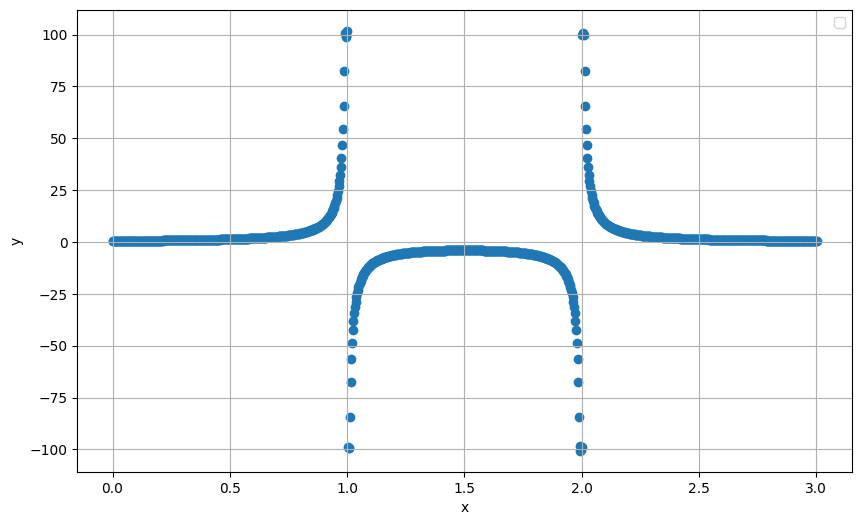

In [3]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(x, y)
ax.set(xlabel='x', ylabel='y')
ax.legend()
ax.grid()
plt.show()

# Some more functions for graphs

In [4]:
colors = ['b','g','r','c','m','y','k']

def plot_aprox_result(x, y, methods_and_coafs, aprox_func, aprox_method_name, plot_full_only = False, figsize=(6,10), linewidth=3):
    
    if plot_full_only:
       num_of_plots = 1
    else:
        num_of_plots = len(methods_and_coafs) + 1

    fig, ax = plt.subplots(num_of_plots, figsize=(10, num_of_plots * 5))
    
    fig.suptitle(aprox_method_name)
    
    if not plot_full_only:
        for idx, (method) in enumerate(methods_and_coafs) :
            ax[idx].scatter(x, y)
            coef = methods_and_coafs[method]
            
            color = colors[idx]
            ax[idx].plot(x, aprox_func(x, *coef), linewidth=linewidth, label=method, color=color)
            ax[idx].set(xlabel='x', ylabel='y')
        
            ax[idx].legend()
            ax[idx].grid()
        
        num_of_plots -= 1
        ax[num_of_plots].scatter(x, y)
        ax[num_of_plots].set(xlabel='x', ylabel='y')

        for idx, (method) in enumerate(methods_and_coafs):
        
            coef = methods_and_coafs[method]
            print(coef)

            color = colors[idx]
            ax[num_of_plots].plot(x, aprox_func(x, *coef), linewidth=linewidth, label=method, color=color)

            ax[num_of_plots].legend()
            ax[num_of_plots].grid()
    else:
        ax.scatter(x, y)
        ax.set(xlabel='x', ylabel='y')
        
        for idx, (method) in enumerate(methods_and_coafs):
        
            coef = methods_and_coafs[method]
            print(coef)
            
            color = colors[idx]
            ax.plot(x, aprox_func(x, *coef ), linewidth=linewidth, label=method, color=color)
        
            ax.legend()
            ax.grid()
        
    plt.show()

In [5]:
def make_table_2d(table_data,
               row_headers = ['exhaustive_search_2d','Gauss','Nelder-Mead'],
               column_headers = ['iter_count','f_calc_count', 'squared error']):
    
    for data in table_data:
        data[2] = round(data[2], 2)
    fig, ax = plt.subplots()
    ax.axis('tight')
    ax.axis('off')
    ax.table(cellText=table_data,
        rowLabels=row_headers,
        colLabels=column_headers,
        loc='center',
        cellLoc='center')

    plt.show()

# Defining loss functions for regression

In [6]:
def rational(x, a, b, c, d):
    return (a * x + b) / (x**2 + c * x + d)

#Spesial version for loss to use in scipy optimisation
def loss_rational(z, *params): 
    x, y = params
    a, b, c, d  = z
    return np.sum((rational(x, a, b, c, d) - y)**2)

#Spesial version for loss to use in LMA method
def loss_rational_lma(z, *params): 
    x, y = params
    a, b, c, d = z
    return rational(x, a, b, c, d) - y

#Functional version for loss to calc precision
def f_loss_rational(x, y, a, b, c, d): 
    return np.sum((rational(x, a, b, c, d) - y)**2)

# Calculating regression coefs by different methods

# Nelder-Mead

In [43]:
eps = 0.001

In [14]:
initial_guess = [0.1, 0.1, 0.1, 0.1]
nelder_mead = opt.minimize(loss_rational, initial_guess, args=(x,y), method='Nelder-Mead', tol = eps)

In [29]:
nelder_mead_result = [nelder_mead['nit'], nelder_mead['nfev'], nelder_mead['fun']]

# Levenberg-Marquardt rational

In [44]:
initial_guess = [-0.1, -0.1, 0.1, 0.1]
lma = opt.least_squares(loss_rational_lma, initial_guess, args=(x,y), ftol=eps, xtol=eps, method='lm')

In [45]:
lma_result = [len(lma['fun']), lma['nfev'], lma['cost']]

# Differential evolution

In [199]:
bounds = np.array([[-10, 10],[-10, 10],[-10, 10],[-10, 10]])
diff_evo = opt.differential_evolution(loss_rational, bounds, args=(x, y), tol=eps)

In [200]:
diff_evo

 message: Optimization terminated successfully.
 success: True
     fun: 195790.57020516615
       x: [-4.169e+00  1.785e+00  7.485e+00 -8.499e+00]
     nit: 119
    nfev: 7290
     jac: [-1.979e-01  1.659e-01  5.504e+00  7.023e+00]

In [62]:
diff_evo_result = [diff_evo['nit'], diff_evo['nfev'], diff_evo['fun']]

# Annieling

In [7]:
from numpy import exp
from numpy.random import randn
from numpy.random import rand

def simulated_annealing(loss, initial_guess, x, y, n_iterations, step_size, max_temp):
	dims = len(initial_guess)
	best = initial_guess

	best_eval = loss(x, y, *best)
	curr, curr_eval = best, best_eval

	temperature_sched = list(max_temp / np.linspace(1, n_iterations, n_iterations))
	
	for t in temperature_sched:
		candidate = curr + randn(dims) * step_size
	
		candidate_eval = loss(x, y, *candidate)

		if candidate_eval < best_eval:
			best, best_eval = candidate, candidate_eval
		else:
			diff = candidate_eval - curr_eval

			# calculate metropolis acceptance criterion
			metropolis = exp(-diff / t)
			# check if we should keep the new point
			if diff < 0 or rand() < metropolis:
				# store the new current point
				curr, curr_eval = candidate, candidate_eval
	return best, best_eval

In [263]:
initial_guess = [-3, 3, -3, 3]
n_iterations = 1000
annealing, score = simulated_annealing(f_loss_rational, initial_guess, x, y, n_iterations=n_iterations, step_size=0.1, max_temp=10000)
annealing, score 

(array([-2.24611828,  2.26558685, -1.96773839,  0.97467881]),
 243011.73790438584)

In [184]:
annealing_result = [n_iterations, n_iterations, score]

# Swarm

In [ ]:
lower_bound = np.array([-10]*4)
upper_bound = np.array([10]*4)
swam, fopt = pso(loss_rational, lower_bound, upper_bound, maxiter=1000, args=(x, y), swarmsize=1000, minfunc=0.001, debug=True)
swam = list(swam)

In [217]:
swarm_result = [84, 84, 195860.0811841173]

# Combined grahps

[ 0.87738459 -1.75603461 -4.0025818   4.00517748]
[-0.09920828 -0.05918013  0.1060809   0.12935835]
[-4.16890136  1.78540798  7.48504772 -8.49924166]
[-2.24611828  2.26558685 -1.96773839  0.97467881]
[2.3157646314188276, -0.809034754572909, -8.015666804712987, 7.024662845943559]


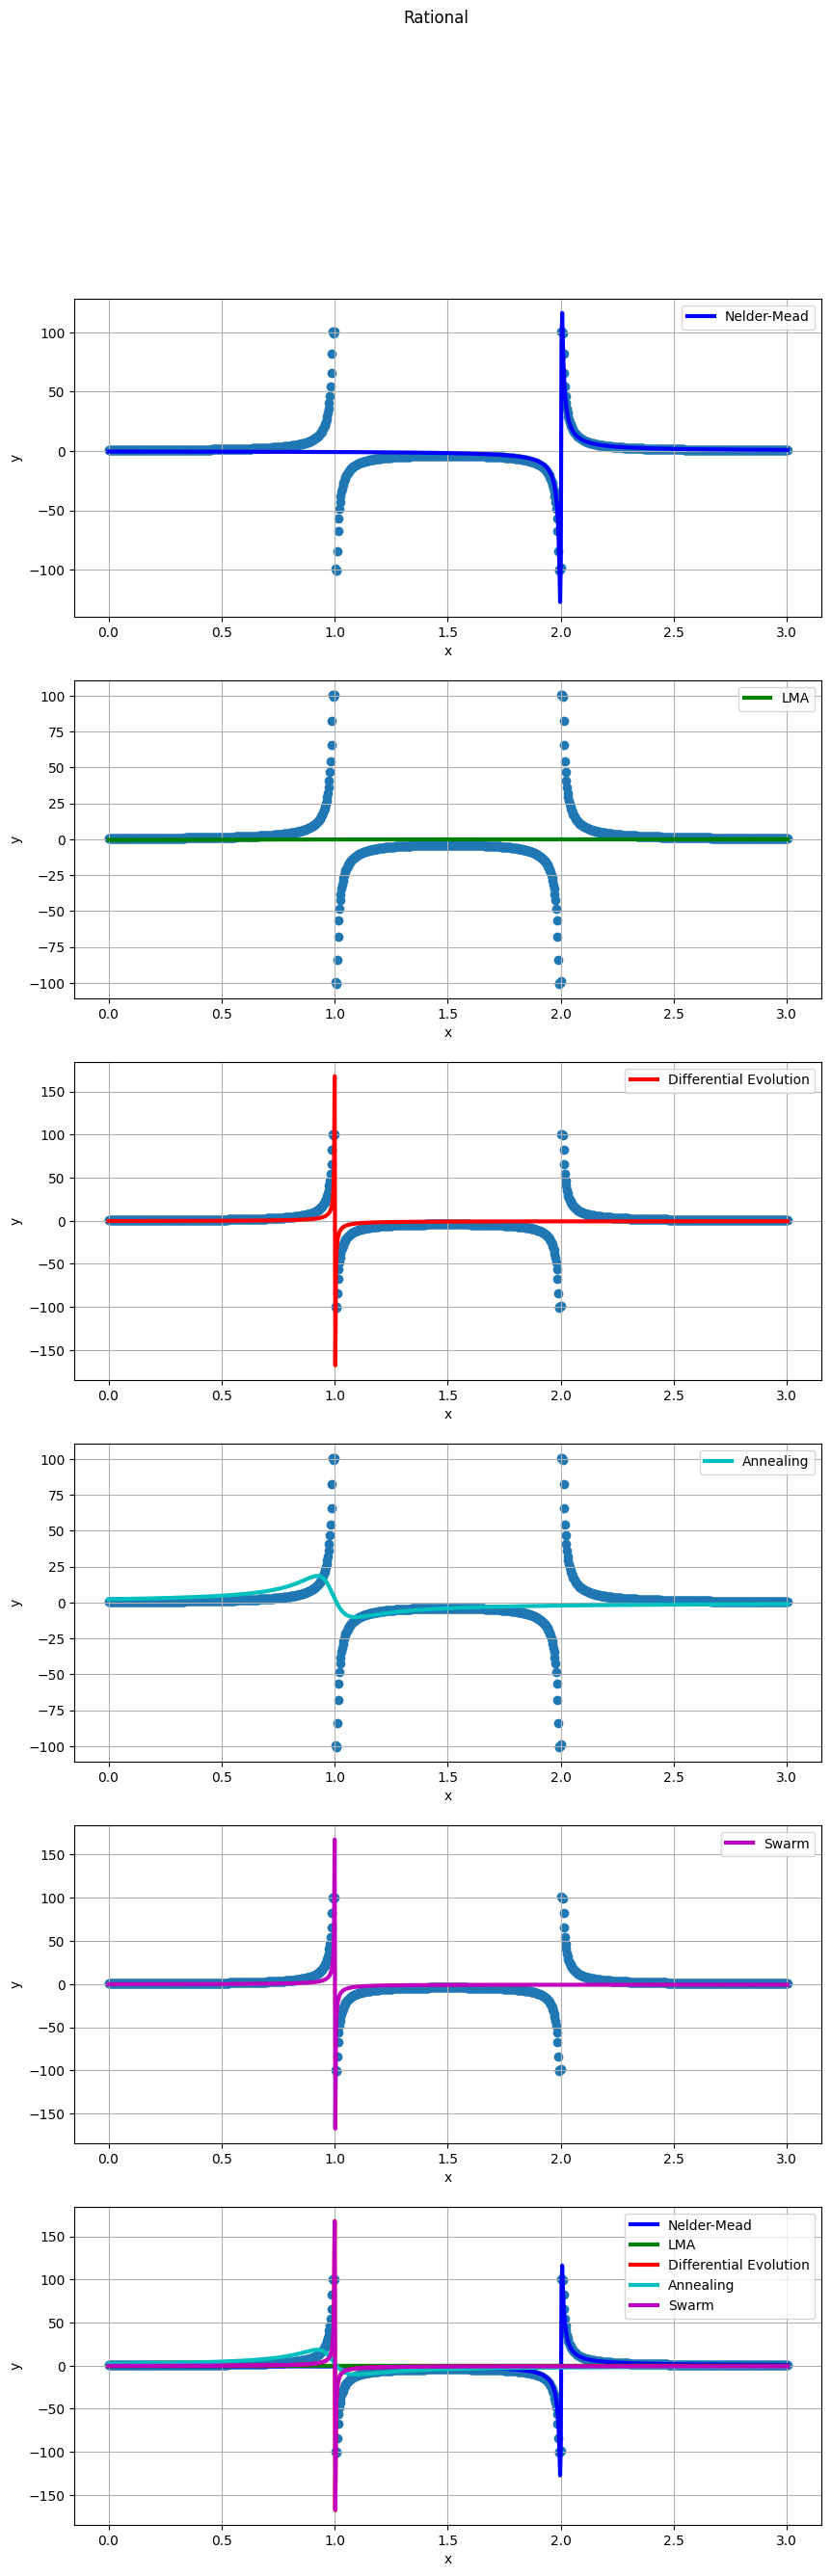

In [264]:
methods_and_coafs_full = {
    'Nelder-Mead': nelder_mead['x'],
    'LMA': lma['x'],
    'Differential Evolution': diff_evo['x'],
    'Annealing': annealing,
    'Swarm':swam
}

plot_aprox_result(x, y, methods_and_coafs_full, rational, 'Rational',figsize=(10,20))

In [ ]:
make_table_2d([nelder_mead_result,
               lma_result,
               diff_evo_result,
               annealing_result,
               swarm_result],
               row_headers = list(methods_and_coafs_full.keys()),
               column_headers = ['iter_count','f_calc_count', 'precision'])

# Part 2

# Application of Simulated Annealing method 
# to solve the Travelling Salesman Problem

## Reading data and getting start coordinates of cities

4635.0


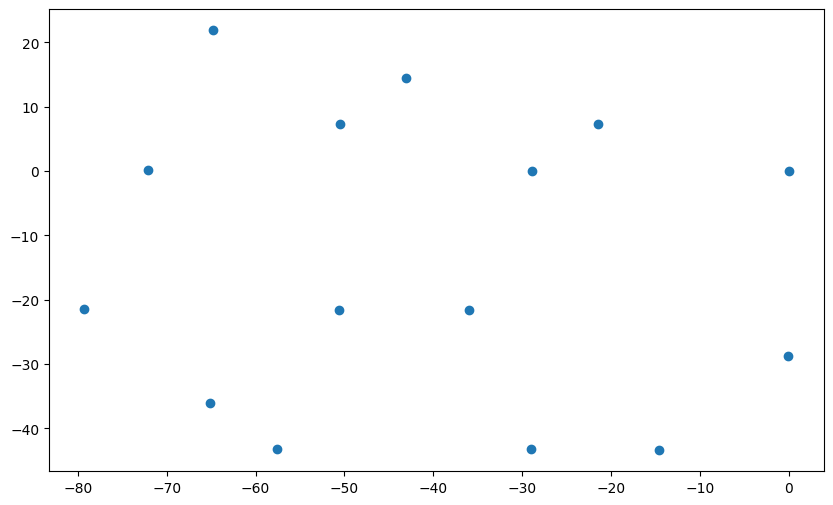

In [69]:
xy = np.loadtxt('Datasets\cities_lau15_xy.txt')

x, y = np.split(xy, 2, axis=1)
x = x.flatten()
y = y.flatten()

plt.figure(figsize=(10,6))
plt.scatter(x,y)

# Getting ditances matrix

In [85]:
matrix = np.loadtxt('Datasets\cities_lau15_dist.txt')

s = [[str(e) for e in row] for row in matrix]
lens = [max(map(len, col)) for col in zip(*s)]
fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
table = [fmt.format(*row) for row in s]
print('\n'.join(table))

0.0 	29.0	82.0	46.0	68.0	52.0	72.0	42.0	51.0	55.0	29.0	74.0	23.0	72.0	46.0
29.0	0.0 	55.0	46.0	42.0	43.0	43.0	23.0	23.0	31.0	41.0	51.0	11.0	52.0	21.0
82.0	55.0	0.0 	68.0	46.0	55.0	23.0	43.0	41.0	29.0	79.0	21.0	64.0	31.0	51.0
46.0	46.0	68.0	0.0 	82.0	15.0	72.0	31.0	62.0	42.0	21.0	51.0	51.0	43.0	64.0
68.0	42.0	46.0	82.0	0.0 	74.0	23.0	52.0	21.0	46.0	82.0	58.0	46.0	65.0	23.0
52.0	43.0	55.0	15.0	74.0	0.0 	61.0	23.0	55.0	31.0	33.0	37.0	51.0	29.0	59.0
72.0	43.0	23.0	72.0	23.0	61.0	0.0 	42.0	23.0	31.0	77.0	37.0	51.0	46.0	33.0
42.0	23.0	43.0	31.0	52.0	23.0	42.0	0.0 	33.0	15.0	37.0	33.0	33.0	31.0	37.0
51.0	23.0	41.0	62.0	21.0	55.0	23.0	33.0	0.0 	29.0	62.0	46.0	29.0	51.0	11.0
55.0	31.0	29.0	42.0	46.0	31.0	31.0	15.0	29.0	0.0 	51.0	21.0	41.0	23.0	37.0
29.0	41.0	79.0	21.0	82.0	33.0	77.0	37.0	62.0	51.0	0.0 	65.0	42.0	59.0	61.0
74.0	51.0	21.0	51.0	58.0	37.0	37.0	33.0	46.0	21.0	65.0	0.0 	61.0	11.0	55.0
23.0	11.0	64.0	51.0	46.0	51.0	51.0	33.0	29.0	41.0	42.0	61.0	0.0 	62.0	23.0
72.0	52.0	31.0	43.0	65.0	

# Visualising routes

### The road from each city goes to each city, according to the distance matrix

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:00<00:00, 44.38it/s]


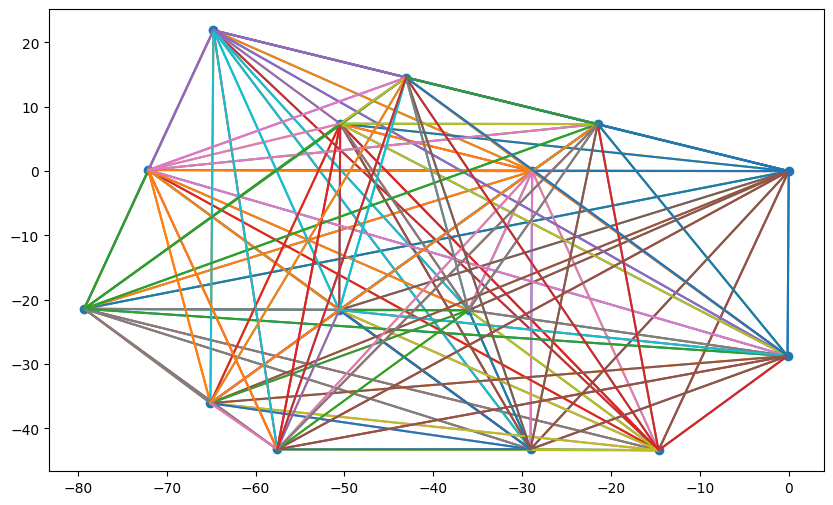

In [70]:
plt.figure(figsize=(10, 6))
plt.scatter(x,y)

for i in tqdm(range(len(x))):
    for j in range(len(x)):
        plt.plot([x[i],x[j]], [y[i], y[j]])

In [94]:
from numpy import exp
from numpy.random import randn
from numpy.random import rand		
import random

def total_dist(route, dist_matrix):
  d = 0.0 
  n = len(route)
  for i in range(n-1):
    d += dist_matrix[route[i], route[i+1]]
  d += dist_matrix[route[n-1], route[0]]
  return d

def swap(route):
  n = len(route)
  result = np.copy(route)
  a = random.randint(0, n-1)
  b = random.randint(0, n-1)
  tmp = result[a]
  result[a] = result[b]; result[b] = tmp
  return result


def simulated_annealing_tsp(loss, dist_matrix, n_cities, n_iterations, max_temp, temp_step=0.1, eps=0.001):
	best = np.arange(n_cities, dtype=np.int64)
	np.random.shuffle(best)
	best_eval = loss(best, dist_matrix)
	curr, curr_eval = best, best_eval	
	temperature_sched = list(max_temp / np.linspace(1, n_iterations, n_iterations))	

	#for t in temperature_sched:
	iter = 0
	while iter < n_iterations and best_eval > eps:
		iter+=1
		candidate = swap(curr)	
		candidate_eval = loss(best, dist_matrix)

		if candidate_eval < best_eval:
			best, best_eval = candidate, candidate_eval
		else:
			diff = curr_eval - candidate_eval 	
			
			max_temp -= temp_step

			if(max_temp <= 0):
				print('temperature = 0')
				break

			# calculate metropolis acceptance criterion
			metropolis = exp(diff / max_temp)
			# check if we should keep the new point
			if diff < 0 or rand() < metropolis:
				# store the new current point
				curr, curr_eval = candidate, candidate_eval
	else:
		if iter >= n_iterations:
			print('iter')
		if best_eval <= eps:
			print('eps')

	return best, best_eval

In [ ]:
route, score = simulated_annealing_tsp(total_dist, matrix, 15, 100000, 1000, 0.001)
print(route,score)

# Visualizing final result

100%|██████████| 14/14 [00:00<00:00, 451.61it/s]


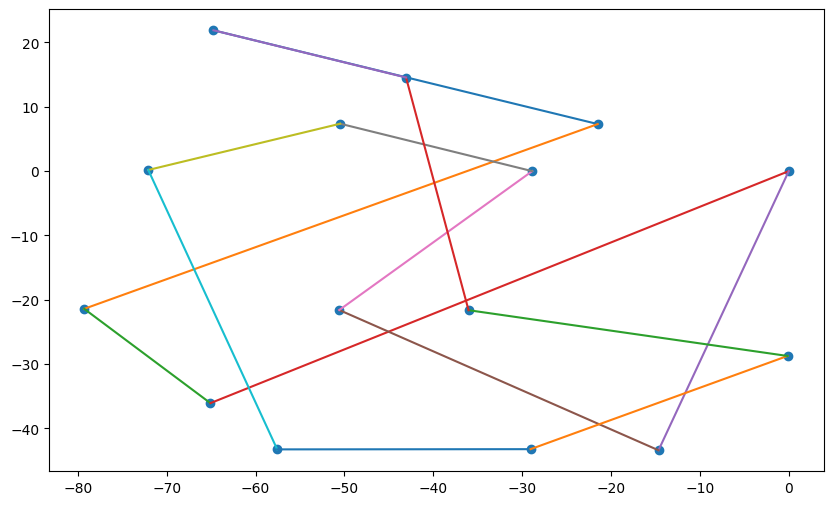

In [97]:
plt.figure(figsize=(10, 6))
plt.scatter(x,y)

for i in tqdm(range(len(route)-1)):
    idx1 = route[i]
    idx2 = route[i+1]
    plt.plot([x[idx1],x[idx2]], [y[idx1], y[idx2]])
    
idx1 = route[len(route)-1]
idx2 = route[0]
plt.plot([x[idx2],x[idx1]], [y[idx2], y[idx1]])

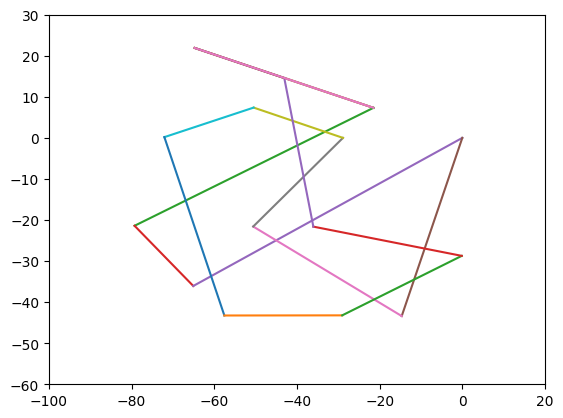

In [96]:
def animate(i):
    if i < 14:
        idx1 = route[i]
        idx2 = route[i+1]
        ax.plot([x[idx1],x[idx2]], [y[idx1], y[idx2]])
    else:
        idx1 = route[len(route)-1]
        idx2 = route[0]
        ax.plot([x[idx2],x[idx1]], [y[idx2], y[idx1]])


import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from IPython.display import display

fig, ax = plt.subplots()
ax.set_xlim([-100,20])
ax.set_ylim([-60,30])
ani = FuncAnimation(fig, animate, frames=15, interval=500, repeat=True)

display(HTML(ani.to_jshtml()))